Overview
Online retail is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

The steps are broadly:

1)Read and understand the data
2)Clean the data
3)Prepare the data for modelling
4)Modelling
5)Final analysis and reco

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [2]:
# read the dataset
retail_df = pd.read_csv("Online+Retail.csv", sep=",", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
###basic attributes of the data
retail_df.shape

(541909, 8)

In [4]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
###null values
(retail_df.isnull().sum()/len(retail_df))*100

InvoiceNo       0.000000
StockCode       0.000000
Description     0.268311
Quantity        0.000000
InvoiceDate     0.000000
UnitPrice       0.000000
CustomerID     24.926694
Country         0.000000
dtype: float64

In [6]:
###drop all rows having missing values
retail_df=retail_df.dropna()
retail_df.shape

(406829, 8)

# Data Preparation

we will do the RFM analysis
R-(Recency)
F-(Frequency)
M-(Monetary)

In [7]:
##new column-amount
retail_df["amount"]=retail_df["Quantity"]*retail_df["UnitPrice"]
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


In [8]:
### out data will be look like before the clustering
##columns name

### Cust_id, recency, frequency, monetary


In [9]:
###monetary
grouped_df=retail_df.groupby("CustomerID")["amount"].sum()
grouped_df=grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [10]:
###Frequence
frequency=retail_df.groupby("CustomerID")["InvoiceNo"].count()
frequency=frequency.reset_index()###to change into df form
frequency.columns=["CustomerID","frequency"]
frequency.head()

,CustomerID,frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [11]:
##merge the two data
grouped_df=pd.merge(grouped_df,frequency,on="CustomerID", how="inner")
grouped_df.head()

,CustomerID,amount,frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [12]:
### recencyany
## convert to datetime
retail_df["InvoiceDate"]=pd.to_datetime(retail_df["InvoiceDate"], format="%d-%m-%Y %H:%M")

In [13]:
###compute the max date\
max_date = max(retail_df["InvoiceDate"])

In [14]:
max_date

Timestamp('2011-12-09 12:50:00')

In [15]:
retail_df["diff"]= max_date-retail_df["InvoiceDate"]

In [16]:
retail_df["diff"]

0        373 days 04:24:00
1        373 days 04:24:00
2        373 days 04:24:00
3        373 days 04:24:00
4        373 days 04:24:00
                ...       
541904     0 days 00:00:00
541905     0 days 00:00:00
541906     0 days 00:00:00
541907     0 days 00:00:00
541908     0 days 00:00:00
Name: diff, Length: 406829, dtype: timedelta64[ns]

In [17]:
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [18]:
###recency column
last_purchase=retail_df.groupby("CustomerID")["diff"].min()

In [19]:
last_purchase

CustomerID
12346.0   325 days 02:33:00
12347.0     1 days 20:58:00
12348.0    74 days 23:37:00
12349.0    18 days 02:59:00
12350.0   309 days 20:49:00
                 ...       
18280.0   277 days 02:58:00
18281.0   180 days 01:57:00
18282.0     7 days 01:07:00
18283.0     3 days 00:48:00
18287.0    42 days 03:21:00
Name: diff, Length: 4372, dtype: timedelta64[ns]

In [20]:
last_purchase=last_purchase.reset_index()

In [21]:
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [22]:
grouped_df=pd.merge(grouped_df,last_purchase,on="CustomerID", how="inner")
grouped_df.head()

,CustomerID,amount,frequency,diff
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [23]:
grouped_df.columns=["CustomerID","amount","frequency","recency"]

In [24]:
grouped_df

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00
...,...,...,...,...
4367,18280.0,180.60,10,277 days 02:58:00
4368,18281.0,80.82,7,180 days 01:57:00
4369,18282.0,176.60,13,7 days 01:07:00
4370,18283.0,2094.88,756,3 days 00:48:00


In [25]:
###Number of days
import datetime as dt

In [26]:
grouped_df["recency"]=grouped_df["recency"].dt.days

In [27]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


In [28]:
###1.outlier treatment
##2. rescaling the varaiable


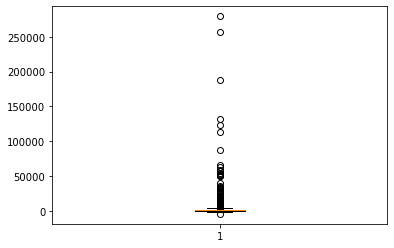

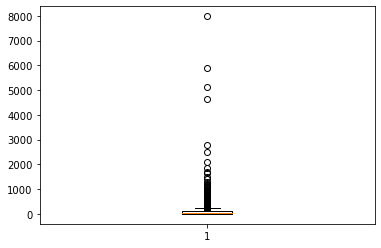

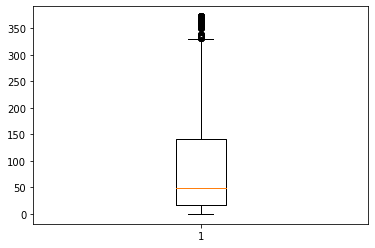

In [29]:
##1. Outlier treatment
columns = ["amount","frequency","recency"]
for i in columns:
    plt.boxplot(grouped_df[i])
    plt.show()


In [30]:
# two types of outliers:
# - statistical---
# - domain specific

In [31]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]



In [32]:
###rescaling
rfm_df = grouped_df[["amount","frequency","recency"]]

scaler = StandardScaler()
rfm_df_scaled=scaler.fit_transform(rfm_df)


In [33]:
rfm_df_scaled

array([[-0.72373821, -0.75288754,  2.30161144],
       [ 1.73161722,  1.04246665, -0.90646561],
       [ 0.30012791, -0.46363604, -0.18365813],
       ...,
       [-0.67769602, -0.70301659,  0.86589794],
       [-0.6231313 , -0.64317145, -0.84705678],
       [ 0.32293822, -0.07464263, -0.50050524]])

In [34]:
rfm_df_scaled=pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns=["amount", "frequency", "recency"]
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


# Modelling

In [35]:
#### K-means with some arbitrary k
kmeans=KMeans(n_clusters=4, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [36]:
kmeans.labels_

array([1, 3, 2, ..., 1, 2, 2])

# finding the optimum number of cluster

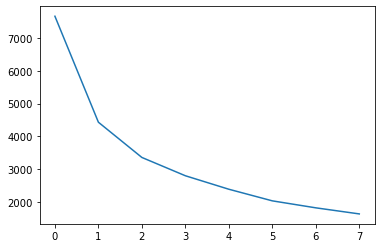

In [37]:
###elbow curve/ssd
ssd=[]
range_n_clusters=[2,3,4,5,6,7,8,9]
for num_clutster in range_n_clusters:
    kmeans=KMeans(n_clusters=num_clutster, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)
####plot the ssds for each  n cluster
plt.plot(ssd)

In [38]:
###0,1,2,3,4 is the index of the cluster

Silhouette Analysis
silhouette score=𝑝−𝑞/(𝑚𝑎𝑥(𝑝,𝑞))
 
𝑝  is the mean distance to the points in the nearest cluster that the data point is not a part of

𝑞  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.(bad cluster)

In [39]:
###silhouette analysis


In [40]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.5415858652525395
For n_clusters=3, the silhouette score is 0.5084896296141937
For n_clusters=4, the silhouette score is 0.4816217519322445
For n_clusters=5, the silhouette score is 0.46627005641897035
For n_clusters=6, the silhouette score is 0.41698547252648926
For n_clusters=7, the silhouette score is 0.415794978066716
For n_clusters=8, the silhouette score is 0.4069092002304887


In [41]:
### final model k=3
kmeans=KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [42]:
kmeans.labels_

array([2, 1, 0, ..., 2, 0, 0])

In [43]:
##assign lael to each customer id
grouped_df['cluster_id']=kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,1
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,2


<AxesSubplot:xlabel='cluster_id', ylabel='amount'>

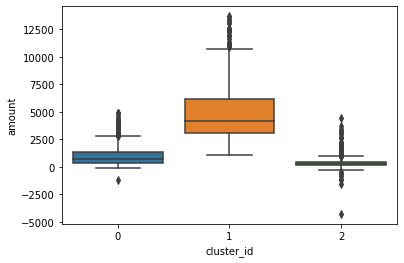

In [44]:
###plot
sns.boxplot(x="cluster_id", y="amount", data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='recency'>

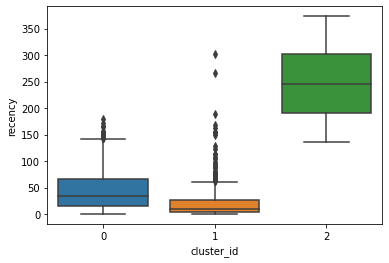

In [45]:
###plot
sns.boxplot(x="cluster_id", y="recency", data=grouped_df)

<AxesSubplot:xlabel='cluster_id', ylabel='frequency'>

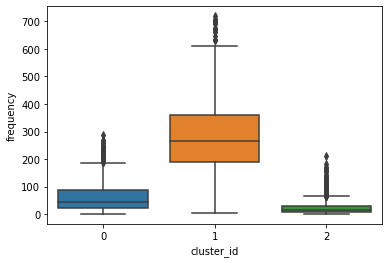

In [46]:
###plot
sns.boxplot(x="cluster_id", y="frequency", data=grouped_df)